# <div style="text-align: center">AVALIANDO CACHORROS</div>

<div style="text-align: right">Projeto deselvolvido por Nadson Brito Gondim</div>
<div style="text-align: right">para fins de aprovação no nanodegree</div>
<div style="text-align: right">"Fundamentos de Data Science II" da Udacity</div>

## __INTRODUÇÃO__

Neste projeto, é feita a análise dos dados contidos no arquivo "twitter-archive-enhanced", concernente aos tweets postados pelo usuário @dog_rates, em que ele vai dando notas para diversos cachorros. Nosso objetivo será completar essas informações com outras, retiradas de um arquivo da Udacity que será baixado programaticamente da internet, bem como outras que conseguiremos a partir da API Tweepy, utilizando os IDs disponibilizados no arquivo "twitter-archive-enhanced".
Depois que tivermos capturado os dados necessários e feita a devida avaliação e limpeza desses dados, iremos tentar responder às questões a seguir.

### Questões:
- A avaliação dos cachorros está relacionada, de alguma forma, ao número de retweets e de faroritos?
- Existe alguma correlação direta entre as notas das avaliações e o nível de confiança das predições do algorítimo?
- Qual estágio de vida dos cachorros recebeu, em média, o maior número de retweets e de favoritos?

## __PREPARAÇÃO__

## Coletando os dados

In [1]:
import pandas as pd
import numpy as np
import requests
import tweepy
import json
import time
import math
import matplotlib.pyplot as plt
import seaborn as sns

% matplotlib inline
sns.set(style="whitegrid", color_codes=True)

In [2]:
#Fazendo o download do arquivo 'image-predictions.tsv'
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
with open(url.split('/')[-1], mode='wb') as file:
    file.write(response.content)

In [3]:
#Fazendo a leitura dos arquivos 'twitter-archive-enhanced.csv' e 'image-predictions.tsv'
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
image_predictions = pd.read_csv('image-predictions.tsv', sep="\s", engine='python')

In [4]:
#Acessando a API Tweepy
CONSUMER_KEY = 'XXXXXXXXXXXXXXXX'
CONSUMER_SECRET = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'

auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
api = tweepy.API(auth)

In [5]:
#Armazenando os dados 'json' de cada tweet em um arquivo de texto 'tweet_json.txt'
file = open('tweet_json.txt', 'w', encoding='utf-8')
tweet_errors = {}
for idx, tweet_id in twitter_archive['tweet_id'].iteritems():
    attempt = False
    while attempt == False:
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            tweet_json = str(tweet._json)+'\n'
            file.write(tweet_json)
            attempt = True
        except Exception as e:
            print(str(idx) + "_" + str(tweet_id) + ": " + str(e))
            if str(e) == "[{'message': 'Rate limit exceeded', 'code': 88}]":
                time.sleep(60 * 15)
                attempt = False
            else:
                tweet_errors[str(idx) + "_" + str(tweet_id)] = str(e)
                attempt = True
file.close()

19_888202515573088257: [{'code': 144, 'message': 'No status found with that ID.'}]
95_873697596434513921: [{'code': 144, 'message': 'No status found with that ID.'}]
118_869988702071779329: [{'code': 144, 'message': 'No status found with that ID.'}]
132_866816280283807744: [{'code': 144, 'message': 'No status found with that ID.'}]
155_861769973181624320: [{'code': 144, 'message': 'No status found with that ID.'}]
247_845459076796616705: [{'code': 144, 'message': 'No status found with that ID.'}]
260_842892208864923648: [{'code': 144, 'message': 'No status found with that ID.'}]
298_837012587749474308: [{'code': 144, 'message': 'No status found with that ID.'}]
382_827228250799742977: [{'code': 144, 'message': 'No status found with that ID.'}]
566_802247111496568832: [{'code': 144, 'message': 'No status found with that ID.'}]
784_775096608509886464: [{'code': 144, 'message': 'No status found with that ID.'}]
900_758740312047005698: [{'message': 'Rate limit exceeded', 'code': 88}]
932_7

In [6]:
# Lista de dicionários para construir linha por linha do arquivo '.txt' e depois converter em um dataframe
tweepy_list = []
with open('tweet_json.txt', 'r', encoding='utf-8') as file: 
    for line in file:
        json_acceptable_string = line[:-1].replace("\"", "'").replace("{'", "{\"").replace("':", "\":").replace(
                    "\": '", "\": \"").replace("',", "\",").replace(", '", ", \"").replace("'}", "\"}").replace(
                    "True", "true").replace("False", "false").replace("None", "null").replace("\\", "\\\\")
        
        try:
            json_line = json.loads(json_acceptable_string)
            tweet_id = json_line['id_str']
            retweet_count = json_line['retweet_count']
            favorite_count = json_line['favorite_count']
            tweepy_list.append({'tweet_id': tweet_id, 'retweet_count': retweet_count, 'favorite_count': favorite_count})
        except Exception as e:
            print(json_acceptable_string + "\n" + str(e) + "\n\n")
df_tweepy = pd.DataFrame(tweepy_list, columns = ['tweet_id', 'retweet_count', 'favorite_count'])
file.close()

## Avaliando os dados

In [7]:
twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [8]:
image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [9]:
df_tweepy.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8556,38676
1,892177421306343426,6288,33140
2,891815181378084864,4171,24950
3,891689557279858688,8684,42056
4,891327558926688256,9445,40213


In [10]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [11]:

image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [12]:
df_tweepy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2344 entries, 0 to 2343
Data columns (total 3 columns):
tweet_id          2344 non-null object
retweet_count     2344 non-null int64
favorite_count    2344 non-null int64
dtypes: int64(2), object(1)
memory usage: 55.0+ KB


In [13]:
twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [14]:
image_predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [15]:
df_tweepy.describe()

,retweet_count,favorite_count
count,2344.000000,2344.000000
mean,3012.443686,8040.640358
std,5012.434517,12102.724515
min,0.000000,0.000000
25%,603.750000,1400.250000
50%,1403.500000,3522.000000
75%,3504.750000,9942.250000
max,77077.000000,142943.000000


In [16]:
twitter_archive['name'].value_counts()

None        745
a            55
Charlie      12
Lucy         11
Cooper       11
Oliver       11
Lola         10
Tucker       10
Penny        10
Bo            9
Winston       9
the           8
Sadie         8
an            7
Bailey        7
Daisy         7
Toby          7
Buddy         7
Oscar         6
Jax           6
Koda          6
Leo           6
Jack          6
Scout         6
Dave          6
Milo          6
Stanley       6
Bella         6
Rusty         6
Chester       5
           ... 
Ulysses       1
Millie        1
Ziva          1
Jiminus       1
Raphael       1
Brooks        1
Petrick       1
Autumn        1
Shooter       1
Aldrick       1
Ronduh        1
Franq         1
by            1
Samsom        1
Tayzie        1
Dewey         1
Walker        1
Mack          1
Sandra        1
Luther        1
Ed            1
Kayla         1
Dante         1
Skittle       1
Gustaf        1
Opie          1
Berkeley      1
Stewie        1
Obi           1
Ebby          1
Name: name, Length: 957,

In [17]:
twitter_archive['rating_denominator'].value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [18]:
twitter_archive['doggo'].value_counts()

None     2259
doggo      97
Name: doggo, dtype: int64

In [19]:
twitter_archive['floofer'].value_counts()

None       2346
floofer      10
Name: floofer, dtype: int64

In [20]:
twitter_archive['pupper'].value_counts()

None      2099
pupper     257
Name: pupper, dtype: int64

In [21]:
twitter_archive['puppo'].value_counts()

None     2326
puppo      30
Name: puppo, dtype: int64

In [22]:
image_predictions['p1'].value_counts()

golden_retriever             150
Labrador_retriever           100
Pembroke                      89
Chihuahua                     83
pug                           57
chow                          44
Samoyed                       43
toy_poodle                    39
Pomeranian                    38
malamute                      30
cocker_spaniel                30
French_bulldog                26
miniature_pinscher            23
Chesapeake_Bay_retriever      23
seat_belt                     22
Staffordshire_bullterrier     20
German_shepherd               20
Siberian_husky                20
Cardigan                      19
web_site                      19
Maltese_dog                   18
Eskimo_dog                    18
Shetland_sheepdog             18
beagle                        18
teddy                         18
Lakeland_terrier              17
Shih-Tzu                      17
Rottweiler                    17
Italian_greyhound             16
kuvasz                        16
          

In [23]:
image_predictions['p2'].value_counts()

Labrador_retriever                104
golden_retriever                   92
Cardigan                           73
Chihuahua                          44
Pomeranian                         42
French_bulldog                     41
Chesapeake_Bay_retriever           41
toy_poodle                         37
cocker_spaniel                     34
miniature_poodle                   33
Siberian_husky                     33
beagle                             28
collie                             27
Pembroke                           27
Eskimo_dog                         27
kuvasz                             26
Italian_greyhound                  22
Pekinese                           21
American_Staffordshire_terrier     21
toy_terrier                        20
malinois                           20
miniature_pinscher                 20
Samoyed                            20
chow                               20
Boston_bull                        19
Norwegian_elkhound                 19
Staffordshir

In [24]:
image_predictions['p3'].value_counts()

Labrador_retriever                79
Chihuahua                         58
golden_retriever                  48
Eskimo_dog                        38
kelpie                            35
kuvasz                            34
chow                              32
Staffordshire_bullterrier         32
beagle                            31
cocker_spaniel                    31
toy_poodle                        29
Pekinese                          29
Pomeranian                        29
Chesapeake_Bay_retriever          27
Great_Pyrenees                    27
Pembroke                          27
French_bulldog                    26
malamute                          26
American_Staffordshire_terrier    24
Cardigan                          23
pug                               23
basenji                           21
bull_mastiff                      20
toy_terrier                       20
Siberian_husky                    19
Shetland_sheepdog                 17
Boston_bull                       17
d

In [25]:
sum(twitter_archive['tweet_id'].duplicated())

0

In [26]:
sum(image_predictions['tweet_id'].duplicated())

0

In [27]:
sum(df_tweepy['tweet_id'].duplicated())

0

In [28]:
sum(twitter_archive['tweet_id'].isnull())

0

In [29]:
sum(image_predictions['tweet_id'].isnull())

0

In [30]:
sum(df_tweepy['tweet_id'].isnull())

0

### Problemas de qualidade:

##### - tabela `twitter_archive`
- As variáveis 'timestamp' e 'retweeted_status_timestamp' são com tipo objeto (string), mas deveriam ser do tipo 'datatime';
- As variáveis que representam IDs são todas do tipo 'int' ou 'float', mas deveriam ser do tipo 'string';
- Em vários casos os campos da coluna 'name' estão preenchidos com palavras que não representam nomes e, nos casos de cachorro sem nome, está preenchida com a palavra 'None', em vez de o campo estar sisplesmente vazio;
- Está faltando o estágio de vida de muitos cachorros, além de que, nesses casos, os campos dessas variáveis foram preenchidos com a palavra 'None' ao invés de estarem simplesmente vazios;
- Um tweet em que a avaliação dada ao cachorro teve o denominador igual a zero;
- A tabela contém classificações que não são originais (retweets).

##### - tabela `image_predictions`
- As variáveis 'tweet_id' e 'img_num' são do tipo 'int', mas deveriam ser do tipo 'string';
- Os nomes de várias colunas não são sugestivos e não deveriam estar abreviados;
- Estão faltando dados de predição, considerando que o número de linhas dessa tabela é menor que o da tabela 'twitter_archive';
- Uso do caractere underline ('_') para separar os nomes compostos das raças de cachorro em vez de se utilizar espaço simples e as iniciais desses nomes não estão todas em caixa-alta.

##### - tabela `df_tweepy`
- Estão fantando alguns tweets que não foram encontrados na API Tweepy a partir dos IDs informados na tabela 'twitter_archive'.

### Problemas de estrutura:

- As colunas 'rating_numerator' e 'rating_denominator' da tabela 'twitter_archive' deveriam formar uma única coluna, chamada 'rating', com dados tipo float, representando a divisão do numerador pelo denominador;
- As colunas 'doggo', 'floofer', 'pupper' e 'puppo' da tabela 'twitter_archive' deveriam formar uma única coluna, chamada 'stage';
- As variáveis de 'df_tweepy' formam uma tabela à parte, mas deveriam somente compor a tabela 'twitter_archive';
- A variável que representa a ordem a que a predição se refere não está representada em uma única coluna da tabela 'image_predictions'.

## Limpando os dados

In [31]:
#Fazendo uma cópia de cada tabela.
twitter_archive_clean = twitter_archive.copy()
image_predictions_clean = image_predictions.copy()
df_tweepy_clean = df_tweepy.copy()

### Dados ausentes

#### `Problema`: Está faltando o estágio de vida de muitos cachorros na tabela 'twitter_archive'

*Não há nada que possa ser feito nesse caso, pois, nesses casos, o texto do tweet simplesmente não informou qual era o estágio de vida*

#### `Problema`: Estão faltando dados de predição na tabela 'image_predictions'

*Também não há nada a fazer, pois não temos acesso à rede neural que gerou as predições*

#### `Problema`: Estão fantando alguns tweets na tabela 'df_tweepy' que não foram encontrados na API Tweepy

*Provavelmente o motivo de não conseguirmos localizar esses tweets na API Tweepy é porque eles devem ter sido apagados, de modo que não temos como resolver esse problema.*

### Tipo de variável inadequado

#### `Problema`: As variáveis 'timestamp' e 'retweeted_status_timestamp' são com tipo objeto (string), mas deveriam ser do tipo 'datatime'

##### Procedimento
*Converter essas duas variáveis do tipo 'string' para o tipo 'datatime'*

##### Código

In [32]:
twitter_archive_clean['timestamp'] = pd.to_datetime(twitter_archive_clean['timestamp'])
twitter_archive_clean['retweeted_status_timestamp'] = pd.to_datetime(twitter_archive_clean['retweeted_status_timestamp'])

##### Teste

In [33]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null datetime64[ns]
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: datetime

#### `Problema`: As variáveis que representam IDs, bem como a variável 'img_num', são do tipo 'int' ou 'float', mas deveriam ser do tipo 'string'

##### Procedimento
*Converter todas essas variáveis para o tipo 'string'. No caso das variáveis 'in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id'e 'retweeted_status_user_id', primeiramente colocar os valores não nulos no formato decimal em vez de notação científica e só depois fazer a conversão para 'string'. Depois que tudo tiver sido convertido, substituir cada ocorrência da palavra 'nan' pelo valor nulo.*

##### Código

In [34]:
#Coloca no formato decimal e então converte para 'string. Por fim, substitui a palavra 'nan' pelo valor nulo.
def edit_format(column, number_characters):
    for idx in twitter_archive_clean.index:
        if not math.isnan(twitter_archive_clean[column][idx]):
            twitter_archive_clean.loc[idx, column] = ('{:' + number_characters + '.0f}').format(
                                    twitter_archive_clean[column][idx])
    twitter_archive_clean[column] = twitter_archive_clean[column].astype(str)
    for idx, item in twitter_archive_clean[column].iteritems():
        if item == 'nan':
            twitter_archive_clean.loc[idx, column] = np.nan

In [35]:
twitter_archive_clean['tweet_id'] = twitter_archive_clean['tweet_id'].astype(str)
image_predictions_clean['tweet_id'] = image_predictions_clean['tweet_id'].astype(str)
image_predictions_clean['img_num'] = image_predictions_clean['img_num'].astype(str)
edit_format('in_reply_to_status_id', '18')
edit_format('in_reply_to_user_id', '10')
edit_format('retweeted_status_id', '18')
edit_format('retweeted_status_user_id', '10')

##### Teste

In [36]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null object
in_reply_to_status_id         78 non-null object
in_reply_to_user_id           78 non-null object
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null object
retweeted_status_user_id      181 non-null object
retweeted_status_timestamp    181 non-null datetime64[ns]
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: datetime64[

In [37]:
image_predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null object
jpg_url     2075 non-null object
img_num     2075 non-null object
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), object(6)
memory usage: 152.1+ KB


In [38]:
twitter_archive_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


### Variáveis com valores que não representam o seu conteúdo ou que deveriam estar com conteúdo vazio.

#### `Problema`: Em vários casos os campos da coluna 'name' estão preenchidos com palavras que não representam nomes e, nos casos de cachorro sem nome, está preenchida com a palavra 'None', em vez de o campo estar sisplesmente vazio.

##### Procedimento
*Substituir pelo valor nulo  todas as palavras que não representam nomes, inclusive a palavra (string) 'None'.*

##### Código

In [39]:
not_name = twitter_archive_clean['name'][twitter_archive_clean['name'].str.islower()]
not_name = not_name.append(pd.Series('None'), ignore_index=True)
for idx, is_true in twitter_archive_clean['name'].isin(not_name).iteritems():
    if is_true:
        twitter_archive_clean.loc[idx, "name"] = np.nan

##### Teste

In [40]:
twitter_archive_clean['name'].unique()

array(['Phineas', 'Tilly', 'Archie', 'Darla', 'Franklin', nan, 'Jax',
       'Zoey', 'Cassie', 'Koda', 'Bruno', 'Ted', 'Stuart', 'Oliver',
       'Jim', 'Zeke', 'Ralphus', 'Canela', 'Gerald', 'Jeffrey', 'Maya',
       'Mingus', 'Derek', 'Roscoe', 'Waffles', 'Jimbo', 'Maisey', 'Lilly',
       'Earl', 'Lola', 'Kevin', 'Yogi', 'Noah', 'Bella', 'Grizzwald',
       'Rusty', 'Gus', 'Stanley', 'Alfy', 'Koko', 'Rey', 'Gary', 'Elliot',
       'Louis', 'Jesse', 'Romeo', 'Bailey', 'Duddles', 'Jack', 'Emmy',
       'Steven', 'Beau', 'Snoopy', 'Shadow', 'Terrance', 'Aja', 'Penny',
       'Dante', 'Nelly', 'Ginger', 'Benedict', 'Venti', 'Goose', 'Nugget',
       'Cash', 'Coco', 'Jed', 'Sebastian', 'Walter', 'Sierra', 'Monkey',
       'Harry', 'Kody', 'Lassie', 'Rover', 'Napolean', 'Dawn', 'Boomer',
       'Cody', 'Rumble', 'Clifford', 'Dewey', 'Scout', 'Gizmo', 'Cooper',
       'Harold', 'Shikha', 'Jamesy', 'Lili', 'Sammy', 'Meatball',
       'Paisley', 'Albus', 'Neptune', 'Quinn', 'Belle', 'Zooey',

#### `Problema`:  Os valores das variáveis de estágio de vida foram preenchidos com a palavra (string) 'None' ao invés de estarem vazios.

##### Procedimento
*Substituir pelo valor nulo  todas as ocorrências da palavra 'None' nas colunas 'doggo', 'floofer', 'pupper' e 'puppo'*

##### Código

In [41]:
for column in ['doggo', 'floofer', 'pupper', 'puppo']:
    for idx, is_true in twitter_archive_clean[column].isin(['None']).iteritems():
        if is_true:
            twitter_archive_clean.loc[idx, column] = np.nan

##### Teste

In [42]:
#Checa o total de ocorrências da palavra 'None' nas colunas 'doggo', 'floofer', 'pupper' e 'puppo'
for column in ['doggo', 'floofer', 'pupper', 'puppo']:
    print(sum(twitter_archive_clean[column].isin(['None'])))

0
0
0
0


### Demais problemas de qualidade

#### `Problema`: Um tweet em que a avaliação dada ao cachorro teve o denominador igual a zero.

##### Procedimento
Apagar da tabela twitter_archive_clean a linha em que o valor da variável 'rating_denominator' é zero. Apagar também as linhas correspondentes nas demais tabelas (com o mesmo tweet_id), caso existam.

##### Código

In [43]:
tweet_id_deleted = twitter_archive_clean[twitter_archive_clean['rating_denominator'] == 0]['tweet_id'].values[0]
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean['rating_denominator'] != 0]
image_predictions_clean = image_predictions_clean[image_predictions_clean['tweet_id'] != tweet_id_deleted]
df_tweepy_clean = df_tweepy_clean[df_tweepy_clean['tweet_id'] != tweet_id_deleted]

##### Teste

In [44]:
twitter_archive_clean[twitter_archive_clean['rating_denominator'] == 0].shape[0]

0

In [45]:
image_predictions_clean[image_predictions_clean['tweet_id'] == tweet_id_deleted].shape[0]

0

In [46]:
df_tweepy_clean[df_tweepy_clean['tweet_id'] == tweet_id_deleted].shape[0]

0

#### `Problema`:  Os nomes de várias colunas da tabela 'image_predictions' não são sugestivos e não deveriam estar abreviados

##### Procedimento
*Renomear as colunas com nomes mais adequados.*

##### Código

In [47]:
image_predictions_clean = image_predictions_clean.rename(index=str, columns={"img_num": "image_number", 
                                            "p1": "prediction1",
                                            "p2": "prediction2",
                                            "p3": "prediction3",
                                            "p1_conf": "prediction1_confidence",
                                            "p2_conf": "prediction2_confidence",
                                            "p3_conf": "prediction3_confidence",
                                            "p1_dog": "prediction1_is_dog",
                                            "p2_dog": "prediction2_is_dog",
                                            "p3_dog": "prediction3_is_dog"})

##### Teste

In [48]:
image_predictions_clean.head()

,tweet_id,jpg_url,image_number,prediction1,prediction1_confidence,prediction1_is_dog,prediction2,prediction2_confidence,prediction2_is_dog,prediction3,prediction3_confidence,prediction3_is_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


#### `Problema`:  Nomes compostos separados com underline ('_') e iniciais em caixa-baixa.

##### Procedimento

*Aplicar uma função que substitue o underline por espaço simples e coloca as iniciais em caixa-alta*

##### Código

In [49]:
# Retorna a predição com um espaço simples no lugar do underline.
def underscore_space(prediction, prediction_number):
    return prediction[prediction_number].replace('_', ' ').title()

In [50]:
image_predictions_clean['prediction1'] = image_predictions_clean.apply(underscore_space, args=('prediction1',), axis=1)
image_predictions_clean['prediction2'] = image_predictions_clean.apply(underscore_space, args=('prediction2',), axis=1)
image_predictions_clean['prediction3'] = image_predictions_clean.apply(underscore_space, args=('prediction3',), axis=1)

##### Teste

In [51]:
image_predictions_clean['prediction1'].value_counts()

Golden Retriever             150
Labrador Retriever           100
Pembroke                      89
Chihuahua                     83
Pug                           57
Chow                          44
Samoyed                       43
Toy Poodle                    39
Pomeranian                    38
Cocker Spaniel                30
Malamute                      30
French Bulldog                26
Miniature Pinscher            23
Chesapeake Bay Retriever      23
Seat Belt                     22
Siberian Husky                20
Staffordshire Bullterrier     20
German Shepherd               20
Cardigan                      19
Web Site                      19
Teddy                         18
Maltese Dog                   18
Eskimo Dog                    18
Beagle                        18
Shetland Sheepdog             18
Lakeland Terrier              17
Shih-Tzu                      17
Rottweiler                    17
Italian Greyhound             16
Kuvasz                        16
          

#### `Problema`:  A tabela 'twitter_archive_clean' contém classificações que não são originais (retweets).

##### Procedimento
*Deixar na tabela apenas as linhas em que o valor da variável 'retweeted_status_id' é nulo.*

##### Código

In [52]:
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean['retweeted_status_id'].isnull()]

##### Teste

In [53]:
twitter_archive_clean['retweeted_status_id'].value_counts()

Series([], Name: retweeted_status_id, dtype: int64)

In [54]:
twitter_archive_clean['retweeted_status_user_id'].value_counts()

Series([], Name: retweeted_status_user_id, dtype: int64)

In [55]:
twitter_archive_clean['retweeted_status_timestamp'].value_counts()

Series([], Name: retweeted_status_timestamp, dtype: int64)

#### `Novo problema`: Com as mudanças feitas na tabela 'twitter_archive_clean', as colunas 'retweeted_status_id', 'retweeted_status_user_id' e 'retweeted_status_timestamp' já não agregam mais nenhuma informação útil.

##### Procedimento
Apagar as colunas 'retweeted_status_id', 'retweeted_status_user_id' e 'retweeted_status_timestamp'.

##### Código

In [56]:
twitter_archive_clean = twitter_archive_clean.drop('retweeted_status_id', axis=1).drop( 'retweeted_status_user_id',
                                                                 axis=1).drop('retweeted_status_timestamp', axis=1)

##### Teste

In [57]:
twitter_archive_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN,NaN,NaN,NaN
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN,NaN,NaN,NaN
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN,NaN,NaN,NaN
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN,NaN,NaN,NaN
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN,NaN,NaN,NaN


### Problemas de estrutura

#### `Problema`:  As colunas 'rating_numerator' e 'rating_denominator' da tabela 'twitter_archive' deveriam formar uma única coluna

##### Procedimento
*Criar uma nova coluna chamada 'rating' para a tabela 'twitter_archive_clean'. Em seguida apagar as colunas 'rating_numerator' e 'rating_denominator'.*

##### Código

In [58]:
rating = []
for idx, row in twitter_archive_clean.iterrows():
    rating.append(twitter_archive_clean['rating_numerator'][idx] / twitter_archive_clean['rating_denominator'][idx])
twitter_archive_clean['rating'] = np.array(rating)
twitter_archive_clean = twitter_archive_clean.drop('rating_numerator', axis=1).drop('rating_denominator', axis=1)

##### Teste

In [59]:
twitter_archive_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,name,doggo,floofer,pupper,puppo,rating
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,Phineas,NaN,NaN,NaN,NaN,1.3
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,Tilly,NaN,NaN,NaN,NaN,1.3
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,Archie,NaN,NaN,NaN,NaN,1.2
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,Darla,NaN,NaN,NaN,NaN,1.3
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,Franklin,NaN,NaN,NaN,NaN,1.2


In [60]:
twitter_archive_clean['rating'].value_counts()

1.200000      504
1.000000      444
1.100000      431
1.300000      307
0.900000      156
0.800000       98
0.700000       53
1.400000       43
0.500000       37
0.600000       32
0.300000       19
0.400000       15
0.200000       11
0.100000        7
42.000000       2
0.000000        2
1.700000        1
1.250000        1
66.600000       1
1.500000        1
7.500000        1
3.428571        1
177.600000      1
0.818182        1
0.636364        1
18.200000       1
0.733333        1
2.700000        1
2.600000        1
Name: rating, dtype: int64

#### `Problema`:  As colunas 'doggo', 'floofer', 'pupper' e 'puppo' da tabela 'twitter_archive' deveriam formar uma única coluna, chamada 'stage'.

##### Procedimento
*Criar uma nova coluna chamada 'stage' que informe o estágio de vida do cachorro e depois apagar as colunas 'doggo', 'floofer', 'pupper' e 'puppo'*

##### Código

In [61]:
stage = [np.nan] * twitter_archive_clean.shape[0]
for idx, row in twitter_archive_clean.iterrows():
    for column in ['doggo', 'floofer', 'pupper', 'puppo']:
        if twitter_archive_clean[column][idx] == column:
            stage[idx] = column
twitter_archive_clean['stage'] = np.array(stage)
twitter_archive_clean = twitter_archive_clean.drop('doggo', axis=1).drop('floofer', axis=1).drop(
                                                            'pupper', axis=1).drop('puppo', axis=1)

##### Teste

In [62]:
twitter_archive_clean['stage'].unique()

array(['nan', 'doggo', 'puppo', 'pupper', 'floofer'], dtype=object)

In [63]:
twitter_archive_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,name,rating,stage
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,Phineas,1.3,nan
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,Tilly,1.3,nan
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,Archie,1.2,nan
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,Darla,1.3,nan
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,Franklin,1.2,nan


#### `Problema`: O dataframe 'df_tweepy_clean' não deveria ser uma tabela à parte, já que suas variáveis fazem parte da unidade observacional de'twitter_archive_clean' .

##### Procedimento
*Mesclar as tabelas 'twitter_archive_clean' e 'df_tweepy', unindo-as pelo 'tweet_id' em comum.*

##### Código

In [64]:
# Optamos por deixar na tabela 'twitter_archive_clean' apenas os tweets que também estejam representados 
# na tabela 'df_tweepy', de modo que os demais tweets serão automaticamente excluídos quando mesclarmos as tabelas.

twitter_archive_clean = pd.merge(twitter_archive_clean, df_tweepy, on='tweet_id', how='right') 

##### Teste

In [65]:
twitter_archive_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,name,rating,stage,retweet_count,favorite_count
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,Phineas,1.3,nan,8556,38676
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,Tilly,1.3,nan,6288,33140
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,Archie,1.2,nan,4171,24950
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,Darla,1.3,nan,8684,42056
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,Franklin,1.2,nan,9445,40213


In [66]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2344 entries, 0 to 2343
Data columns (total 12 columns):
tweet_id                 2344 non-null object
in_reply_to_status_id    77 non-null object
in_reply_to_user_id      77 non-null object
timestamp                2173 non-null datetime64[ns]
source                   2173 non-null object
text                     2173 non-null object
expanded_urls            2116 non-null object
name                     1390 non-null object
rating                   2173 non-null float64
stage                    2173 non-null object
retweet_count            2344 non-null int64
favorite_count           2344 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(2), object(8)
memory usage: 238.1+ KB


#### `Problema`: A variável que representa a ordem a que a predição se refere não está representada em uma única coluna da tabela 'image_predictions_clean'.

##### Procedimento
*Criar duas cópias da tabela 'image_predictions_clean'; Acrescentar a coluna 'prediction_order' às três tabelas de predição (a original e as duas cópias), cada qual preenchida com uma determinada ordem (1, 2 ou 3); Apagar em cada uma dessas tabelas as colunas referentes a predições de ordem diferente da coluna 'prediction_ordem'; Renomear em cada tabela as colunas de predições, de modo que não conste no nome da coluna a ordem da predição; Por fim, concatenar as tabelas, juntando todo o conteúdo das três em uma única tabela.*

##### Código

In [67]:
image_predictions_clean2 = image_predictions_clean.copy()
image_predictions_clean3 = image_predictions_clean.copy()
image_predictions_clean['prediction_order'] = np.repeat("1", image_predictions_clean.shape[0])
image_predictions_clean2['prediction_order'] = np.repeat("2", image_predictions_clean.shape[0])
image_predictions_clean3['prediction_order'] = np.repeat("3", image_predictions_clean.shape[0])

In [68]:
# Retorna a tabela especificada, mas com duas colunas apagadas e uma renomeada.
def drop_wrong_columns(table):
    if table is image_predictions_clean:
        prediction_order = '1'
    elif table is image_predictions_clean2:
        prediction_order = '2'
    elif table is image_predictions_clean3:
        prediction_order = '3'
    for order in ['1','2','3']:
        for column in ['prediction' + order, 'prediction' + order + '_confidence', 'prediction' + order + '_is_dog']:
            if 'prediction' + order != 'prediction' + prediction_order:
                table = table.drop(column, axis=1)
            else:
                table = table.rename(index=str, columns={column: column.replace(order, '')})
    return table

In [69]:
image_predictions_clean = drop_wrong_columns(image_predictions_clean)
image_predictions_clean2 = drop_wrong_columns(image_predictions_clean2)
image_predictions_clean3 = drop_wrong_columns(image_predictions_clean3)
image_predictions_clean = pd.concat([image_predictions_clean, image_predictions_clean2,
                                          image_predictions_clean3], ignore_index=True)

##### Teste

In [70]:
image_predictions_clean.head()

,tweet_id,jpg_url,image_number,prediction,prediction_confidence,prediction_is_dog,prediction_order
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh Springer Spaniel,0.465074,True,1
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,Redbone,0.506826,True,1
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German Shepherd,0.596461,True,1
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian Ridgeback,0.408143,True,1
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,Miniature Pinscher,0.560311,True,1


In [71]:
image_predictions_clean.tail()

,tweet_id,jpg_url,image_number,prediction,prediction_confidence,prediction_is_dog,prediction_order
6220,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,German Short-Haired Pointer,0.175219,True,3
6221,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,Spatula,0.040836,False,3
6222,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Kelpie,0.031379,True,3
6223,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Papillon,0.068957,True,3
6224,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,Banana,0.076110,False,3


In [72]:
twitter_archive_clean['rating'].value_counts()

1.200000      503
1.000000      444
1.100000      431
1.300000      307
0.900000      156
0.800000       98
0.700000       53
1.400000       43
0.500000       37
0.600000       32
0.300000       19
0.400000       15
0.200000       11
0.100000        7
42.000000       2
0.000000        2
1.700000        1
1.250000        1
66.600000       1
1.500000        1
7.500000        1
3.428571        1
177.600000      1
0.818182        1
0.636364        1
18.200000       1
0.733333        1
2.700000        1
2.600000        1
Name: rating, dtype: int64

#### `Novo problema`: Presença de valores totalmente fora do esperado na coluna 'rating' da tabela 'twitter_archive_clean' e que não interessam de forma alguma para a nossa análise

##### Procedimento
Apagar as linhas da tabela 'twitter_archive_clean' com valor maior ou igual a dois ou com mais de uma casa decimal.

##### Código

In [73]:
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean['rating'] < 2]
mask = [(value*10).is_integer() for value in twitter_archive_clean['rating'].values]
twitter_archive_clean = twitter_archive_clean[mask]

##### Teste

In [74]:
twitter_archive_clean['rating'].unique()

array([1.3, 1.2, 1.4, 0.5, 1.7, 1.1, 1. , 0.6, 1.5, 0. , 0.7, 0.3, 0.8,
       0.9, 0.4, 0.2, 0.1])

Gravaremos, então, as tabelas 'twitter_archive_clean' e 'image_predictions_clean', com os dados devidamente limpos e estruturados, em arquivos 'csv'.

In [75]:
twitter_archive_clean.to_csv('twitter_archive_master.csv', index=False)
image_predictions_clean.to_csv('image_predictions_clean.csv', index=False)

## __EXPLORAÇÃO E VISUALIZAÇÃO__

### Variáveis que interessam para a análise, classificadas por tipo:

##### Variáveis categóricas:
- stage
- prediction_is_dog

##### Variáveis quantitativas:
- rating
- retweet_count
- favorite_count
- prediction_confidence

In [76]:
#Analisando alguns dados estatísticos descritivos
twitter_archive_clean.describe()

,rating,retweet_count,favorite_count
count,2160.000000,2160.000000,2160.000000
mean,1.061296,2687.162500,8654.469444
std,0.221164,4633.531429,12341.048358
min,0.000000,0.000000,51.000000
25%,1.000000,588.000000,1864.250000
50%,1.100000,1297.000000,3933.000000
75%,1.200000,3095.500000,10837.000000
max,1.700000,77077.000000,142943.000000


In [77]:
image_predictions_clean.describe()

,prediction_confidence
count,6.225000e+03
mean,2.631537e-01
std,2.908324e-01
min,1.740170e-10
25%,5.123350e-02
50%,1.351790e-01
75%,3.796240e-01
max,1.000000e+00


Observa-se, por exemplo, o seguuinte:
- a avaliação dos cachorros varia de 0 a 1,7 e tem média de aproximadamente 1,06.
- A média do número de retweets é de aproximadamente 2.687,23.
- A mediana do grau de confiança das predições foi de aproximadamente 13,5%.

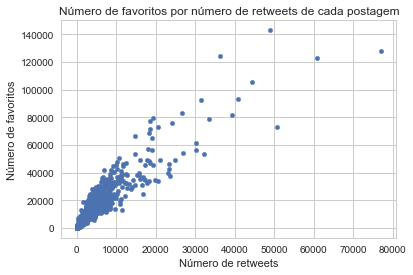

In [78]:
twitter_archive_clean.plot(kind='scatter', x="retweet_count", y="favorite_count")
plt.title("Número de favoritos por número de retweets de cada postagem")
plt.xlabel("Número de retweets")
plt.ylabel("Número de favoritos");

- O gráfico acima sugere que, quando o número de retweets aumenta, o número de favoritos também tende a aumentar, e vice-versa.

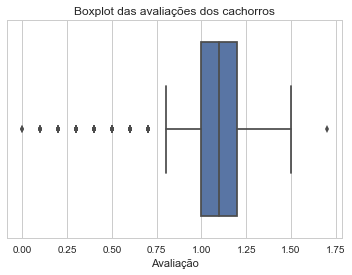

In [79]:
plot = sns.boxplot(x='rating', data=twitter_archive_clean)
plot.set_title("Boxplot das avaliações dos cachorros")
plot.set_xlabel("Avaliação");

- O gráfico mostra a presenta de alguns poucos outliers no que se refere à variável 'rating'. O 1ª quartil corresponde à avaliação de '1,0', o 2º à avaliaçãode '1,1' e o 3º à avaliação de '1,2'.

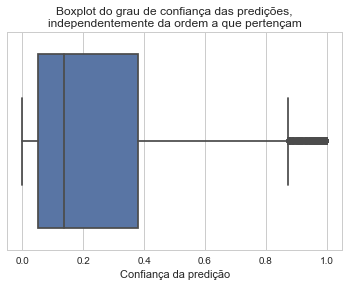

In [80]:
plot = sns.boxplot(x='prediction_confidence', data=image_predictions_clean)
plot.set_title("Boxplot do grau de confiança das predições,\nindependentemente da ordem a que pertençam")
plot.set_xlabel("Confiança da predição");

- Esse gráfico mostra a distriuição do grau de confiança das predições em geral, independentemente da sua ordem. Podemos verificar que a maioria das predições não chegam a alcançar uma confiança de pelo menos 50%,

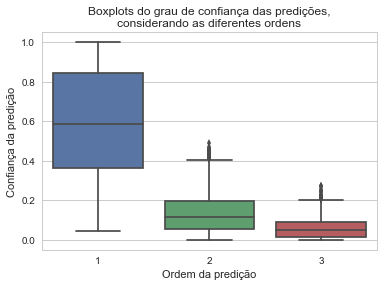

In [81]:
plot = sns.boxplot(x='prediction_order', y='prediction_confidence', data=image_predictions_clean)
plot.set_title("Boxplots do grau de confiança das predições,\nconsiderando as diferentes ordens")
plot.set_xlabel("Ordem da predição")
plot.set_ylabel("Confiança da predição");

- Esse gráfico separa os graus de confiança das predições de acordo com suas respectivas ordens. Ele mostra que, no geral, a confiança da predição 1 é bem superior a das predições 2 e 3, chegando, inclusise, em alguns casos, à alcançar a confiança máxima de 100%.

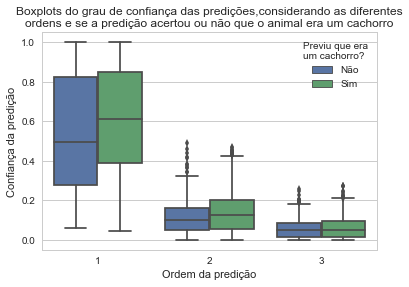

In [82]:
plot = sns.boxplot(x='prediction_order', y='prediction_confidence', hue='prediction_is_dog', data=image_predictions_clean)
plot.set_title("Boxplots do grau de confiança das predições,considerando as diferentes\nordens e se a predição acertou ou não que o animal era um cachorro") 
plot.set_xlabel("Ordem da predição")
plot.set_ylabel("Confiança da predição")
handles, _ = plot.get_legend_handles_labels()
plot.legend(handles=handles, labels=["Não","Sim"]).set_title("Previu que era\num cachorro?");

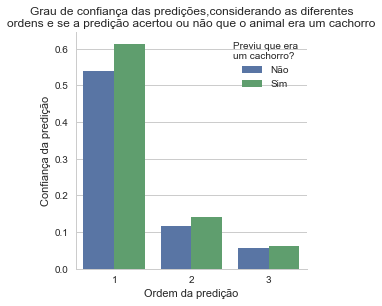

In [83]:
plot = sns.factorplot(x='prediction_order', y='prediction_confidence', hue='prediction_is_dog',
                               kind='bar', ci=None, legend=False, data=image_predictions_clean)
plot.ax.set_title("Grau de confiança das predições,considerando as diferentes\nordens e se a predição acertou ou não que o animal era um cachorro"); 
plot.ax.set_xlabel("Ordem da predição")
plot.ax.set_ylabel("Confiança da predição")
handles, _ = plot.ax.get_legend_handles_labels()
plot.ax.legend(handles=handles, labels=["Não","Sim"]).set_title("Previu que era\num cachorro?");

- Ambos os gráfico acima mostram, por exemplo, que para todas as três ordens de predição, as predições que acertam que a imagem é de um cachorro tentem a ter um grau de confiança um pouco superior àquelas que erram o tipo de animal.

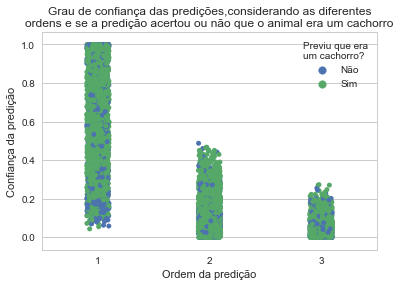

In [84]:
plot = sns.stripplot(x='prediction_order', y='prediction_confidence', hue='prediction_is_dog',
                                                data=image_predictions_clean, jitter=True)
plot.set_title("Grau de confiança das predições,considerando as diferentes\nordens e se a predição acertou ou não que o animal era um cachorro"); 
plot.set_xlabel("Ordem da predição")
plot.set_ylabel("Confiança da predição")
handles, _ = plot.get_legend_handles_labels()
plot.legend(handles=handles, labels=["Não","Sim"]).set_title("Previu que era\num cachorro?");

- O gráfico mostra que, em relação ao total de previsões de cada ordem, foram poucas as previsões que erraram o tipo de animal, considerando que a maior parte está pintada de verde.

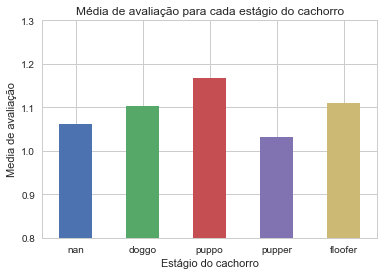

In [85]:
twitter_archive_clean.groupby('stage').mean()['rating'][np.r_[2, 0, 4, 3, 1]].plot(kind='bar', ylim=(0.8, 1.3))
plt.title("Média de avaliação para cada estágio do cachorro")
plt.xlabel("Estágio do cachorro")
plt.ylabel("Media de avaliação")
plt.xticks(rotation='horizontal');

- O gráfico mostra que o estágio 'doggo' é o que tem a maior média de avaliação e o 'puppo' é o que tem a menor média de avaliação. 

### Questão 1: A avaliação dos cachorros está relacionada, de alguma forma, ao número de retweets e de faroritos?

In [86]:
twitter_archive_clean.groupby('rating').mean()['retweet_count'].append(pd.Series({1.6 : 0})).sort_index()

0.0    1828.000000
0.1    1917.714286
0.2    1230.000000
0.3     917.947368
0.4    1064.200000
0.5    1197.594595
0.6    1008.906250
0.7     998.471698
0.8     872.142857
0.9     791.320513
1.0    1452.905405
1.1    2143.948956
1.2    2983.512922
1.3    6427.501629
1.4    8342.720930
1.5       0.000000
1.6       0.000000
1.7       7.000000
dtype: float64

In [87]:
twitter_archive_clean.groupby('rating').mean()['favorite_count'].append(pd.Series({1.6 : 0})).sort_index()

0.0    13538.000000
0.1     4740.428571
0.2     2301.272727
0.3     2327.631579
0.4     2657.466667
0.5     3639.378378
0.6     2645.281250
0.7     2953.905660
0.8     2374.642857
0.9     2371.294872
1.0     4019.936937
1.1     6654.076566
1.2    10591.155070
1.3    20981.469055
1.4    26134.790698
1.5      149.000000
1.6        0.000000
1.7      128.000000
dtype: float64

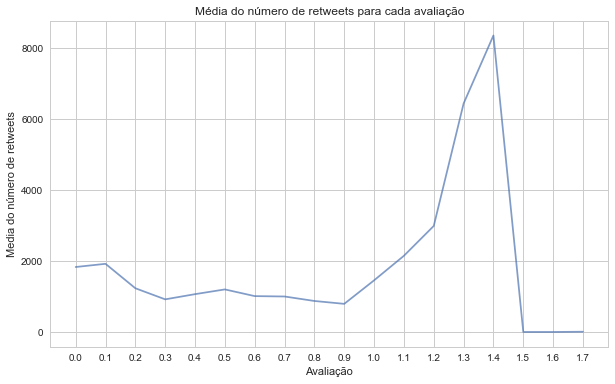

In [88]:
location = np.arange(18)
labels = [str(i/10) for i in location]
plt.figure(figsize=(10,6))
plt.plot(location, twitter_archive_clean.groupby('rating').mean()['retweet_count'].append(
                                              pd.Series({1.6 : 0})).sort_index(), alpha=.7)
plt.xticks(location, labels, rotation='horizontal')
plt.title("Média do número de retweets para cada avaliação")
plt.xlabel("Avaliação")
plt.ylabel("Media do número de retweets");

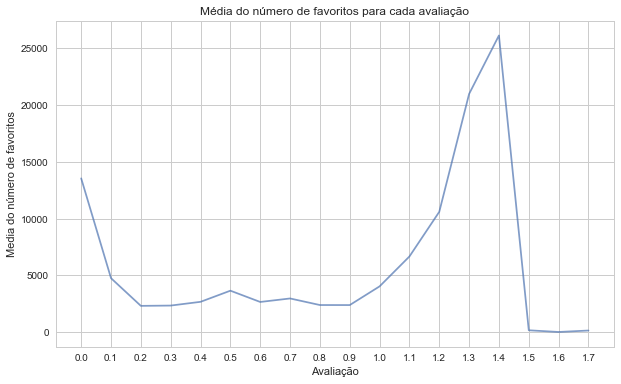

In [89]:
location = np.arange(18)
labels = [str(i/10) for i in location]
plt.figure(figsize=(10,6))
plt.plot(location, twitter_archive_clean.groupby('rating').mean()['favorite_count'].append(
                                              pd.Series({1.6 : 0})).sort_index(), alpha=.7)
plt.xticks(location, labels, rotation='horizontal')
plt.title("Média do número de favoritos para cada avaliação")
plt.xlabel("Avaliação")
plt.ylabel("Media do número de favoritos");

- Os dois gráficos acima são muito parecidos. Eles sugerem que, quando a avaliação do cachorro é estremamente baixa (0,0 e 0,1), os números de retweets e de favoritos são, em média, relativamente elevados, se compararmos com as avaliações seguintes. Mas, aumentando apenas um pouco a avaliação, o número médio de retweets e de favoritos já cai drasticamente. A partir daí, os gráficos mantém mais ou menos uma constância de poucos retweets e favoritos, voltando a crescer esse número quando as avaliações superam a nota de '0,9'. O gráfico é crescente a partir daí, atingindo seu pico na avaliação de '1,4', e depois decresce drasticamente.

**Respondendo a primeira pergunta, é possível afirmar que parece haver sim uma relação entre a avaliação do cachorro e o número de retweets e de favoritos. Essa relação é mais evidente no intervalo de avaliações de 0,9 a 1,4, no qual os gráficos das médias de retweets e de favoritos são estritamente crescentes. Também se destaca o fato de que avaliações com nota 0,0 e 0,1 tem um um tanto alto número de retweets e favoritos, se compararmos com as demais avaliações com nota abaixo de 0,9, todas com número muito baixo de retweets e favoritos.**

### Questão 2: Existe alguma correlação direta entre as notas das avaliações e o nível de confiança das predições do algorítimo?

In [90]:
#  Retorna uma tabela mesclando a tabela 'twitter_archive_clean' e a parte da tabela
#  'image_predictions_clean' referente a 'prediction_order' informada.

def plot_confidence(order):
    mask = image_predictions_clean['prediction_order'] == order
    table = pd.merge(twitter_archive_clean, image_predictions_clean[mask], on='tweet_id', how='right')
    return table

In [91]:
plot_confidence('1').groupby('rating').mean()['prediction_confidence']

rating
0.0    0.718887
0.1    0.665055
0.2    0.672933
0.3    0.449529
0.4    0.467073
0.5    0.581369
0.6    0.465423
0.7    0.550779
0.8    0.533640
0.9    0.556493
1.0    0.577139
1.1    0.615840
1.2    0.621049
1.3    0.618956
1.4    0.628607
Name: prediction_confidence, dtype: float64

In [92]:
plot_confidence('2').groupby('rating').mean()['prediction_confidence']

rating
0.0    0.106253
0.1    0.061123
0.2    0.081085
0.3    0.120814
0.4    0.159796
0.5    0.113180
0.6    0.189002
0.7    0.142422
0.8    0.128482
0.9    0.132095
1.0    0.136614
1.1    0.134558
1.2    0.133681
1.3    0.136465
1.4    0.113918
Name: prediction_confidence, dtype: float64

In [93]:
plot_confidence('3').groupby('rating').mean()['prediction_confidence']

rating
0.0    0.035923
0.1    0.026324
0.2    0.056468
0.3    0.062729
0.4    0.084312
0.5    0.054352
0.6    0.074402
0.7    0.063559
0.8    0.056663
0.9    0.063910
1.0    0.062165
1.1    0.059694
1.2    0.058506
1.3    0.060799
1.4    0.038518
Name: prediction_confidence, dtype: float64

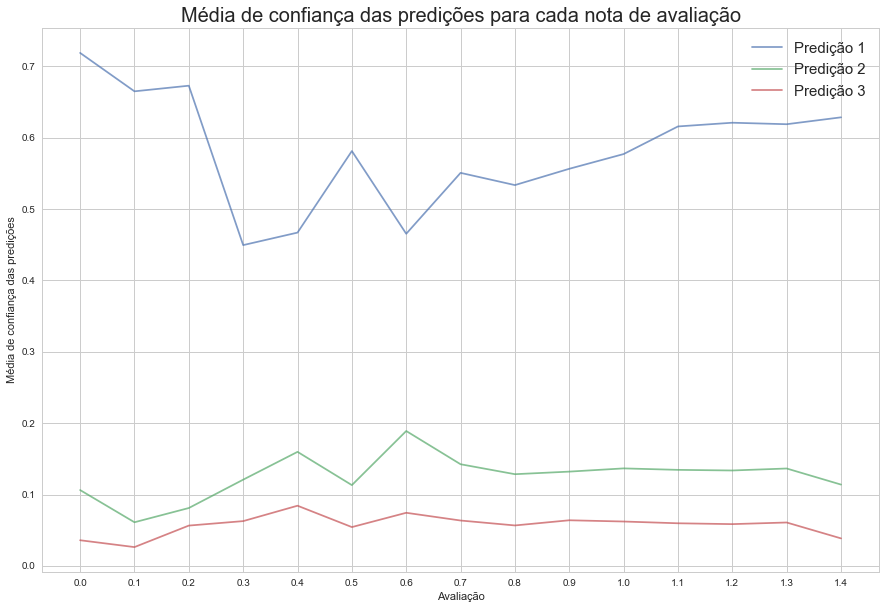

In [94]:
width = 0.3
ind = np.arange(15)
labels = [str(i/10) for i in ind]
plt.figure(figsize=(15,10))
mean_confidence = []
for i in [1,2,3]:
    mean_confidence.append(plot_confidence(str(i)).groupby('rating').mean()['prediction_confidence'])
plot1 = plt.plot(ind, mean_confidence[0], color='b', alpha=.7)
plot2 = plt.plot(ind, mean_confidence[1], color='g', alpha=.7)
plot3 = plt.plot(ind, mean_confidence[2], color='r', alpha=.7)
plt.xticks(ind, labels, rotation='horizontal')
plt.xlabel('Avaliação')
plt.ylabel('Média de confiança das predições')
plt.legend(["Predição 1","Predição 2", "Predição 3"], fontsize=15)
plt.title('Média de confiança das predições para cada nota de avaliação', fontsize=20);

- Conforme a figura acima, os gráficos das médias de confiança de todas as três predições são bastante irregulares. Ora são crescentes, ora decrescentes. Isso sugere que ter uma avaliação mais alta ou mais baixa não implica que a confiança do algorítimo será melhor ou pior. Note-se que a partir da avaliação de '0.8' o gráfico do grau de confiança da predição 1 se torna estritamente crescente, mas é bem possível que isso seja apenas uma coincidência.

**Respondendo a segunda pergunta, não parece haver nenhuma relação direta entre a avaliação dada a cada cachorro e o nível de confiança das respectivas predições feitas pelo algorítimo.**

### Questão 3: Qual estágio de vida dos cachorros recebeu, em média, o maior número de retweets e de favoritos? 

In [95]:
twitter_archive_clean.groupby('stage').mean()['retweet_count'][np.r_[2, 0, 4, 3, 1]]

stage
nan        2659.776800
doggo      4060.554054
puppo      4409.080000
pupper     2302.982759
floofer    2113.700000
Name: retweet_count, dtype: float64

In [96]:
twitter_archive_clean.groupby('stage').mean()['favorite_count'][np.r_[2, 0, 4, 3, 1]]

stage
nan         8662.572842
doggo      12778.756757
puppo      16170.320000
pupper      6494.534483
floofer     7981.600000
Name: favorite_count, dtype: float64

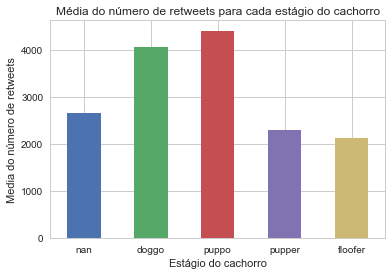

In [97]:
twitter_archive_clean.groupby('stage').mean()['retweet_count'][np.r_[2, 0, 4, 3, 1]].plot(kind='bar')
plt.title("Média do número de retweets para cada estágio do cachorro")
plt.xlabel("Estágio do cachorro")
plt.ylabel("Media do número de retweets")
plt.xticks(rotation='horizontal');

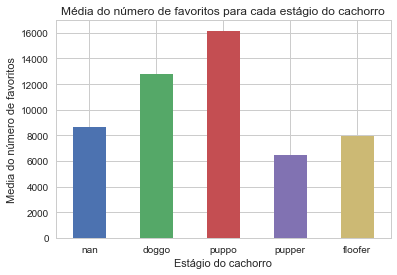

In [98]:
plot = twitter_archive_clean.groupby('stage').mean()['favorite_count'][np.r_[2, 0, 4, 3, 1]].plot(kind='bar')
plt.title("Média do número de favoritos para cada estágio do cachorro")
plt.xlabel("Estágio do cachorro")
plt.ylabel("Media do número de favoritos")
plt.xticks(rotation='horizontal');

- Com excessão do estágio "floofer", o ranking dos estágios com mais retweets é semelhante ao ranking daqueles com mais favoritos. Os dois gráficos sugerem que, em média, os cães do estágio 'puppo' receberam mais retweets e favoritos que os demais.

**Respondendo a última pergunta, o estágio 'puppo' é o que tem a maior média tanto de retweets como de favoritos.**

## CONCLUSÃO

A análise realizada sugere que a avaliação de cachorros está relacionada ao número de retweets e favoritos, principalmente no intervalo de avaliações variando de '0,9' a '1,4', no qual ocorre que quanto maior a nota, maior tende a ser o número de retweets e de favoritos. Desse modo, podemos afirmar que as avaliações feitas são dotadas de certa consistência. É bem provável que os usuários que tiveram acesso às publicações concordem, em grande parte, com as avaliações feitas, compartilhando da visão do avaliador, o que explicaria o número grande de retweets e favoritos. Mas é possível também que a nota tenha impactado o julgamento desses usuários, incentivando ou desestimulando eles a retweetarem ou favoritarem. 

Quanto ao motivo para que as notas mais baixas (zero) correspondam a um número elevado de retweets e favoritos, poderíamos cogitar que essas postagens sejam muito chamativas, seja por mostrarem cachorros muito feios ou situações bizarras, ou ainda por fazer algum tipo de brincadeira. Por outro lado, não conseguimos explicar o número reduzido de retweets e favoritos para avaliações acima de '1,4'.

Acerca das predições do algorítimo, pudemos constatar que o nível de confiança da predição 1 é muito superior ao das predições 2 e 3. Vimos também que as avaliações dos cachorros não mantém correlação direta com o nível de confiança das predições do algorítimo, embora, para avaliações acima de '0,8', a confiança da predição 1 pareça melhorar com o aumento da avaliação.

Por fim, vimos que os usuários parecem gostar mais de cachorros no estágio 'puppo', que foi o que recebeu maior número de retweets e favoritos. Por outro lado, parecem não gostar muito dos cachorros nos estágios 'pupper' e 'floofer', considerando o reduzido número de retweets e favoritos. Coincidência ou não, o estágio 'puppo' foi também o que recebeu, em média, a melhor avaliação, em comparação com os demais estágios.

Cabe destacar que os resultados a que chegamos não são conclusivos. As correlações observadas podem muito bem terem sido frutos do acaso. Para um estudo mais detalhado seria necessária a utilização de estatística inferencial.

##### Limitaçoes
- Alguns tweets retornaram mensagem de erro quando tentamos complementar os dados da tabela inicial a partir da API Tweepy. Infelizmente, foi necessário excluir esses dados na fase de limpeza (no momento em que mesclamos as tabelas).
- Em um tweet foi feita avaliação com denominador zero, de modo que também precisou ser excluído.
- Encontramos casos em que o valor da variável 'rating' fugia completamente do esperado. Imaginamos que deve ter havido algum erro de digitação no momento da postagem, mas, como não sabemos exatamente qual deveria ser a avaliação, foi preciso excluir esses tweets.
- Para responder à segunda pergunta nos baseamos em uma mesclagem das tabelas 'twitter_archive_clean' e 'image_predictions_clean', o que também acabou resultando em dados excluídos. Isso explica o porquê de o eixo x ser levemente diferente nos gráficos da 1ª e da 2ª questão.
- As avaliações dos cachorros estão no formato (numerador/denominador). Para realizar nossa análise, foi preciso efetuar essa divisão, de modo que os resultados são apresentados em um formato que não se assemelha ao original.
- O usuário @dog_rates parece não levar muito a sério às avaliações dos cachorros, colocando em alguns casos determinadas notas por motivos alheios ao próprio animal, outras vezes deixando sua avaliação em imagens que sequer são realmente de cachorros. Isso dificultou muito a limpeza desses dados indesejados.

## REFERÊNCIAS

- https://docs.python.org/3/library/index.html
- https://pandas.pydata.org/pandas-docs/stable/
- https://matplotlib.org/users/pyplot_tutorial.html
- https://seaborn.pydata.org/tutorial/categorical.html
- http://docs.tweepy.org/en/v3.5.0/